In [1]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from shared_utilities import helpers

In [2]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

VFHM-FNVT
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [3]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

In [4]:
conn = helpers.get_redshift_connection("qa-app", "stlrlagalaxy")

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


In [5]:
cursor = conn.cursor()
sql = "SELECT * FROM dw.cohortpurchase"
cursor.execute(sql)



In [6]:
data = cursor.fetchall()

In [7]:
df_original = pd.DataFrame(data=data, columns=[desc[0] for desc in cursor.description])

In [8]:
cursor.close()
conn.close()

In [9]:
df = df_original.copy()

## Cleaning

We can group by to see aggregations absed on the product groupings. We can see that some have a (min, max) range of (0, 0) which won't be applicable for us, so we can remove those.

We can also create a year and month column, if we wanted to do any analysis on a particular month or year.

In [10]:
(df
    .groupby(['productgrouping'])
    .agg({
        'dimcustomermasterid': ['count'],
        'revenue': ['min', 'max', 'mean', 'median', 'sum'],
        'daysoutfromevent': ['min', 'max', 'mean', 'median', 'sum']
    })
)

dimcustomermasterid revenue                                \
                                 count     min        max        mean median   
productgrouping                                                                
Comp                             54208     0.0       0.00    0.000000    0.0   
Full Season                     531739     1.9    7450.00   85.771477   56.0   
Group                            76167     2.5   39200.00  297.048956   80.0   
Individual                      174259     0.0  437473.69  179.352989   80.0   
Mini Plan                        22228     0.0    4000.00   94.900732   74.0   
Other                              692     0.0    6465.00  500.474350    0.0   
Partial Plan                     30458     5.0    1448.00   91.639815   70.0   
Premium Membership               25035     0.0       0.00    0.000000    0.0   
Premium Purchase                  2071     0.0       0.00    0.000000    0.0   

                                daysoutfromevent                            \
                            sum              min    max        mean median   
productgrouping                                                              
Comp                       0.00              0.0  541.0   99.854782   23.0   
Full Season         45608039.35              0.0  738.0  295.225430  292.0   
Group               22625327.86              0.0  706.0   19.395254    6.0   
Individual          31253872.54             -5.0  457.0   21.924425    7.0   
Mini Plan            2109453.46              0.0  457.0   60.492284   39.0   
Other                 346328.25              0.0  216.0   26.233645   11.0   
Partial Plan         2791165.50              0.0  756.0  138.529464  128.0   
Premium Membership         0.00              0.0  510.0  278.425604  281.0   
Premium Purchase           0.00              0.0  411.0   39.313375   16.0   

                                 
                            sum  
productgrouping                  
Comp                  5412928.0  
Full Season         156980218.0  
Group                 1476871.0  
Individual            3811912.0  
Mini Plan             1344562.0  
Other                    5614.0  
Partial Plan          4217391.0  
Premium Membership    6970385.0  
Premium Purchase        81418.0

In [11]:
df = df[~df['productgrouping'].isin(['Comp', 'Premium Membership', 'Premium Purchase', 'Other'])]

In [12]:
(df
    .groupby(['productgrouping'])
    .agg({
        'dimcustomermasterid': ['count'],
        'revenue': ['min', 'max', 'mean', 'median', 'sum'],
        'daysoutfromevent': ['min', 'max', 'mean', 'median', 'sum']
    })
)

dimcustomermasterid revenue                                \
                              count     min        max        mean median   
productgrouping                                                             
Full Season                  531739     1.9    7450.00   85.771477   56.0   
Group                         76167     2.5   39200.00  297.048956   80.0   
Individual                   174259     0.0  437473.69  179.352989   80.0   
Mini Plan                     22228     0.0    4000.00   94.900732   74.0   
Partial Plan                  30458     5.0    1448.00   91.639815   70.0   

                             daysoutfromevent                            \
                         sum              min    max        mean median   
productgrouping                                                           
Full Season      45608039.35              0.0  738.0  295.225430  292.0   
Group            22625327.86              0.0  706.0   19.395254    6.0   
Individual       31253872.54             -5.0  457.0   21.924425    7.0   
Mini Plan         2109453.46              0.0  457.0   60.492284   39.0   
Partial Plan      2791165.50              0.0  756.0  138.529464  128.0   

                              
                         sum  
productgrouping               
Full Season      156980218.0  
Group              1476871.0  
Individual         3811912.0  
Mini Plan          1344562.0  
Partial Plan       4217391.0

In [13]:
df['month'] = df['eventdate'].dt.month
df['month'].sample(10)

47060      8.0
245392    10.0
705246     8.0
335408     4.0
358285     7.0
824102     5.0
650531     7.0
585543    10.0
675692     9.0
59743      3.0
Name: month, dtype: float64

In [14]:
df['year'] = df['eventdate'].dt.year
df['year'].sample(10)

812772    2021.0
371992    2017.0
162512    2013.0
370568    2017.0
334705    2017.0
633009    2022.0
309361    2016.0
35240     2012.0
230114    2015.0
148420    2013.0
Name: year, dtype: float64

## Visualizations

### Line Plot


Text(0.5, 1.0, 'Revenue By Date')

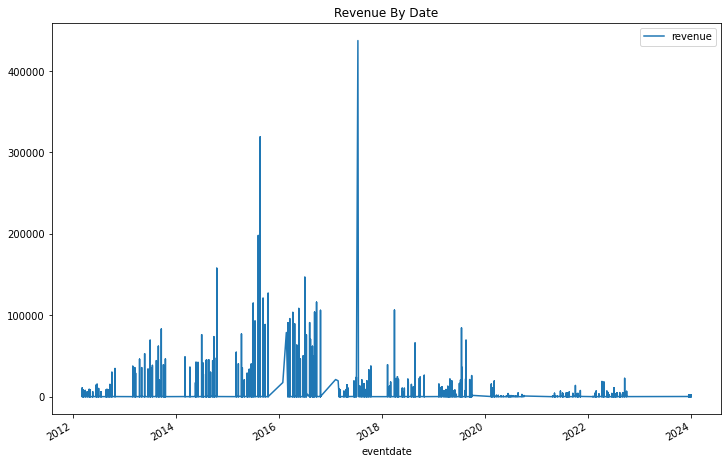

In [15]:
df.plot(x='eventdate', y='revenue', figsize=(12,8))
plt.title('Revenue By Date')

### Boxplot

We can see the number of purchases with a boxplot for the year. Showing the distribution is a little skewed to before 2018.

This however, doesn't display revenue well, as seen in the second visual. This shows that box charts are more useful when there is a fairly close distribution of data. With too much skew (such as in revenue), the chart will be too difficult to interpret. This can be minimized by selecting features, such as in the third and fourth box charts, where revenue is only readable for Mini Plan buyers.

From the matplotlib docs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
```
     Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
                  |-----:-----|
  o      |--------|     :     |--------|    o  o
                  |-----:-----|
flier             <----------->            fliers
                       IQR
```

<AxesSubplot:>

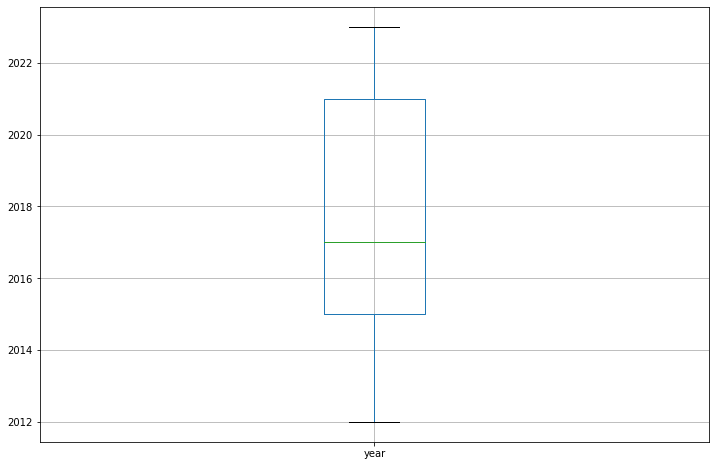

In [16]:
df.boxplot('year', figsize=(12, 8))

Text(0.5, 1.0, 'Revenue Box Chart')

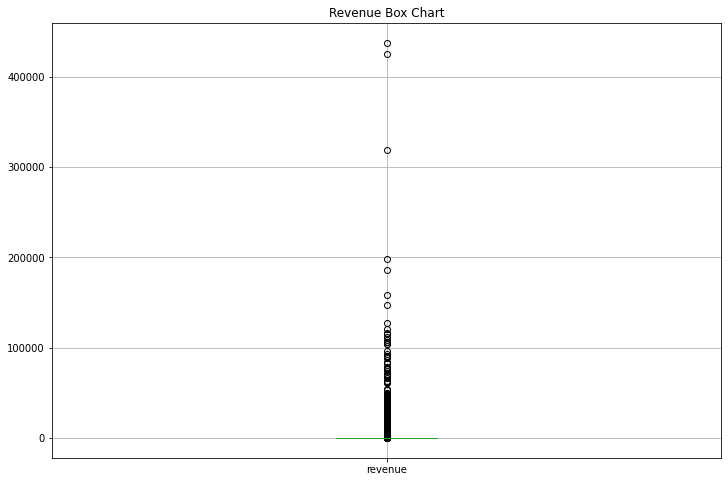

In [17]:
df.boxplot('revenue', figsize=(12, 8))
plt.title('Revenue Box Chart')

Text(0.5, 1.0, 'Revenue for Mini Plan')

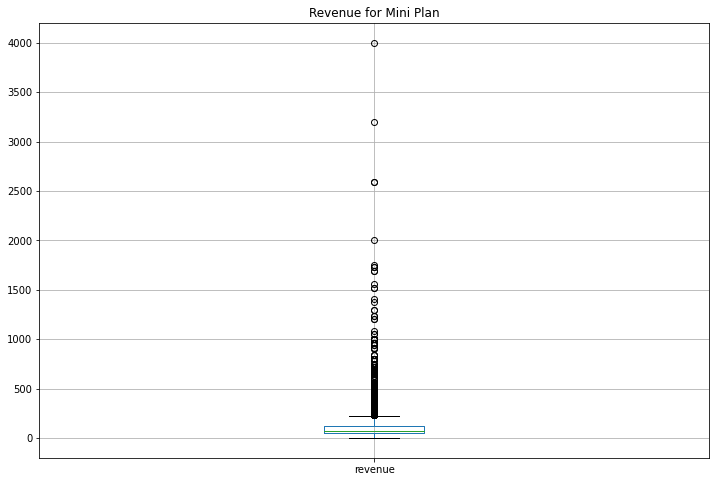

In [18]:
df[df['productgrouping'] == 'Mini Plan'].boxplot('revenue', figsize=(12, 8))
plt.title('Revenue for Mini Plan')

Here we pivot the data, as its current in format where we have a row per customer and a column for what type of plan they purchased. Now with the pivoted_df we have a row per customer and a column of how much they spent on each type of plan.

In [19]:
pivot_df = df.pivot(index=['id', 'year'], columns='productgrouping', values='revenue')

In [20]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 834851 entries, (1, 2012.0) to (916857, 2019.0)
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Full Season   531739 non-null  float64
 1   Group         76167 non-null   float64
 2   Individual    174259 non-null  float64
 3   Mini Plan     22228 non-null   float64
 4   Partial Plan  30458 non-null   float64
dtypes: float64(5)
memory usage: 74.4 MB


<AxesSubplot:>

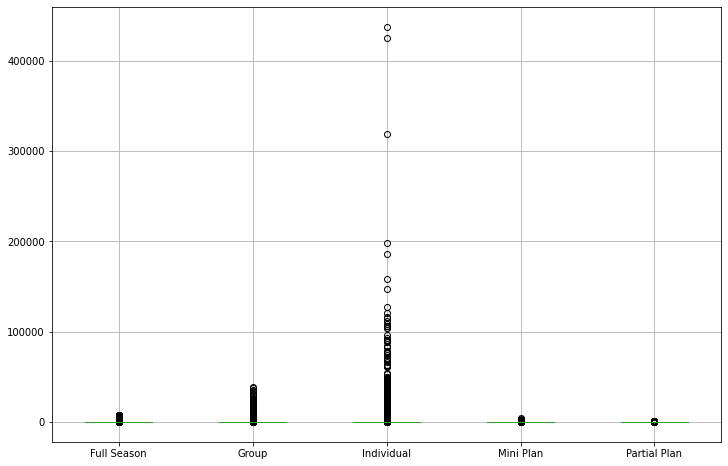

In [21]:
pivot_df[['Full Season', 'Group', 'Individual', 'Mini Plan', 'Partial Plan']].boxplot(figsize=(12,8))

Text(0, 0.5, 'Production')

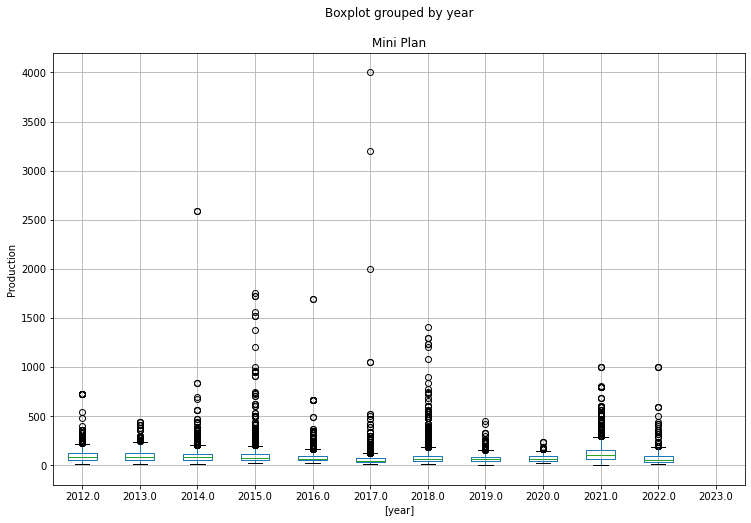

In [22]:
pivot_df.boxplot(column='Mini Plan', by=['year'], 
                       figsize=(12, 8))

plt.ylabel('Production')

### Bar Charts

Simpler to read total values by categorical groupings.

For some reason df.plot.bar took >20 minutes to run, so I used seaborn to run it.

This helps show categorical data, such as the product groupings and the variance in revenue per customer. Similarly, we could group by and sum the data for each product grouping to see the overall value of each grouping.

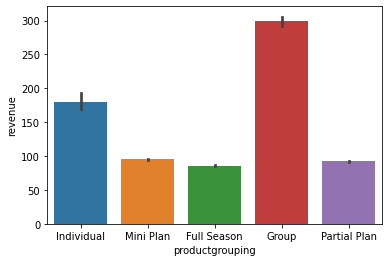

In [114]:
ax = sns.barplot(x="productgrouping", y="revenue", data=df)

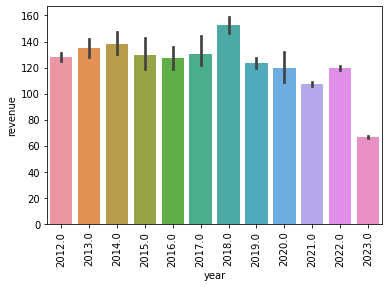

In [119]:
ax = sns.barplot(x="year", y="revenue", data=df)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

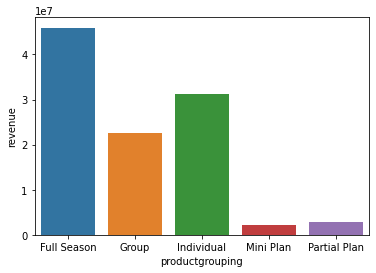

In [137]:
ax = sns.barplot(x="productgrouping", y="revenue", data=df.groupby('productgrouping', as_index=False).sum())

### KDE (Kernel Density Estimate)

This is basically how dense or sparse your data is. Similar to a histogram generally. Like a histogram it can help show the skew of your data, in particular it can help show how dense or sparse some areas of your data are.

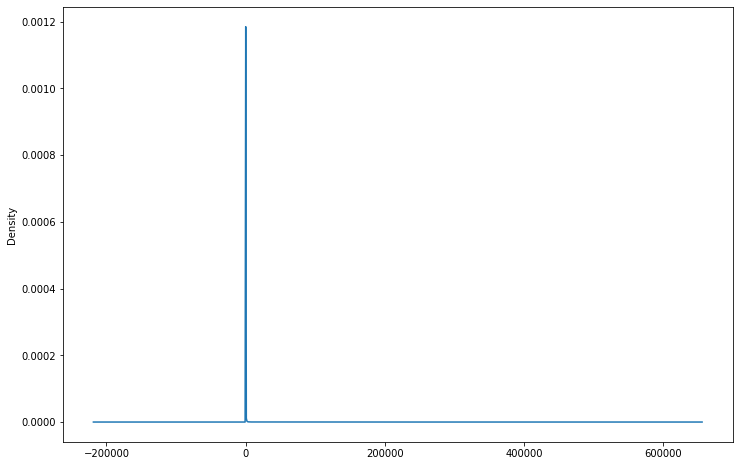

In [139]:
df['revenue'].plot.kde(figsize=(12,8))
plt.show()

### Scatter

Scatter plots help find relationships between points. Such as the plot below showing revenue and attendance count. You can see theres a possible correlation between how many games someone attends and how much they spend on a ticket, if they've gone to more games they could possibly want a better seat next time.

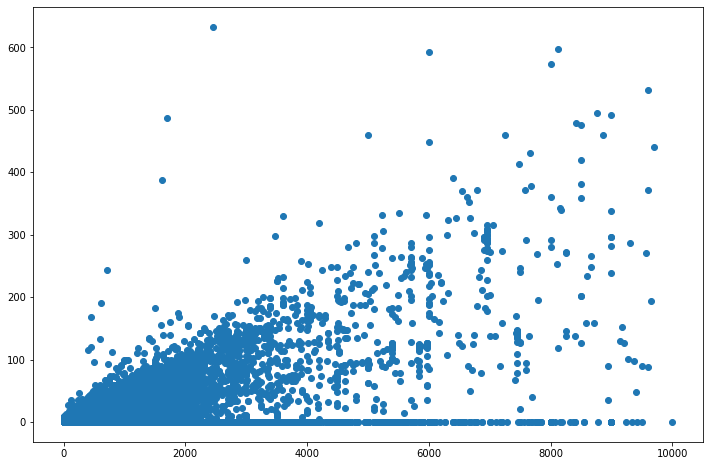

In [153]:
plt.figure(figsize=(12,8))
plt.scatter(df[df['revenue']<10000]['revenue'], df[df['revenue']<10000]['attendancecount'])

<AxesSubplot:xlabel='revenue', ylabel='attendancecount'>

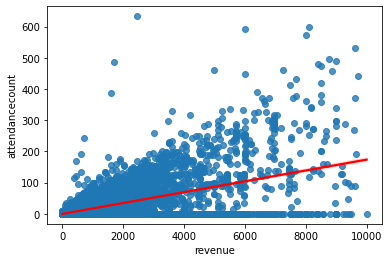

In [156]:
sns.regplot(x='revenue', y='attendancecount', data=df[df['revenue']<10000], line_kws={"color": "red"})

<AxesSubplot:xlabel='revenue', ylabel='attendancecount'>

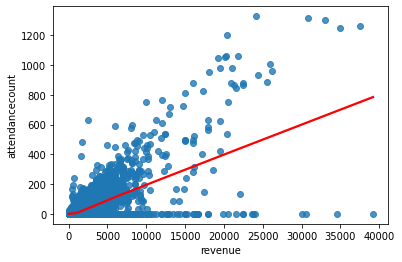

In [163]:
sns.regplot(x='revenue', y='attendancecount', data=df, line_kws={"color": "red"}, lowess=True)

### Heatmap

This helps show correlation between variables in your dataframe

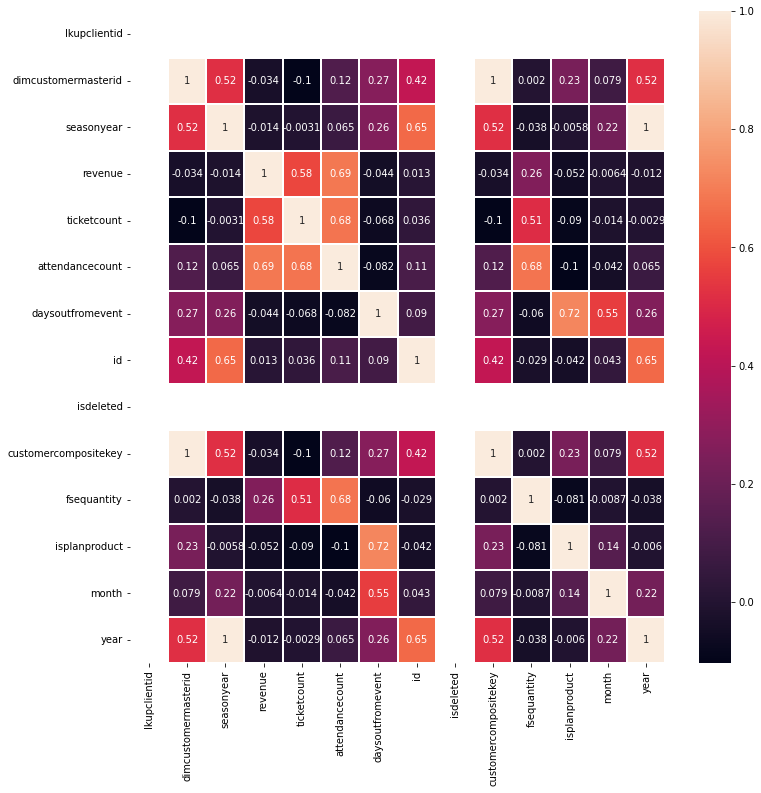

In [175]:
fig, ax = plt.subplots(figsize=(12,12))
corr = df.corr()
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, linewidths=2)

# Identifying and Visualizing Probabilistic And Statistical Relationships

(Basically part 3)

/Users/petermorrison/opt/miniconda3/envs/package/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


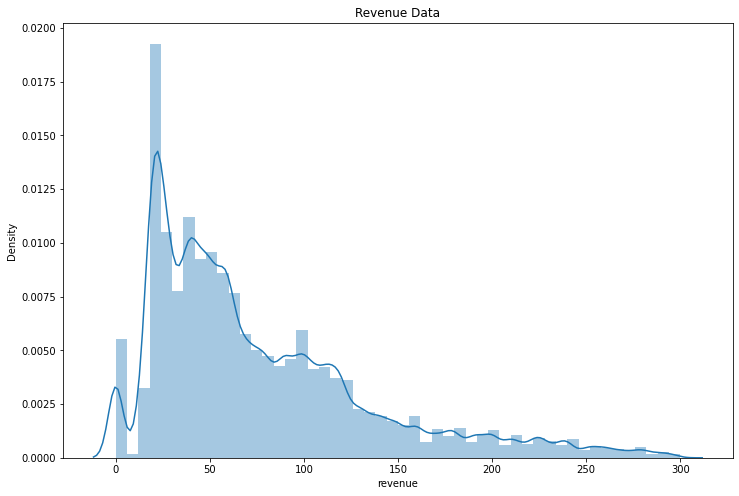

In [20]:
plt.figure(figsize=(12, 8))

sns.distplot(df[df['revenue'] < 300]['revenue'])
plt.title('Revenue Data')

plt.show()

/Users/petermorrison/opt/miniconda3/envs/package/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


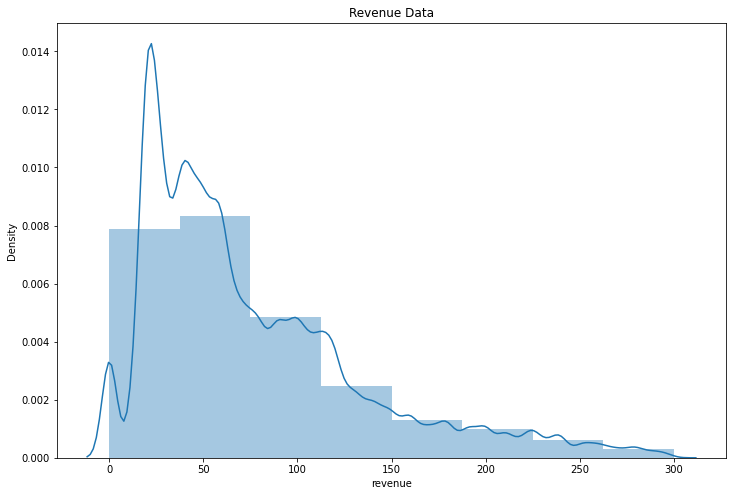

In [22]:
plt.figure(figsize=(12, 8))

sns.distplot(df[df['revenue'] < 300]['revenue'], bins=8)
plt.title('Revenue Data')
plt.show()

In [23]:
df.columns

Index(['lkupclientid', 'dimcustomermasterid', 'promotion', 'team', 'eventtime',
       'eventday', 'eventname', 'eventdate', 'salesrep', 'productgrouping',
       'pricelevel', 'pricecode', 'seasonyear', 'purchasedate', 'revenue',
       'ticketcount', 'attendancecount', 'genre', 'daysoutfromevent',
       'secondaryaction', 'insertdatetime', 'updatedatetime', 'id',
       'gamenumber', 'venuename', 'sessionname', 'subproductname',
       'producttype', 'isrenewalevent', 'date_effective_start',
       'date_effective_end', 'isdeleted', 'customercompositekey',
       'fsequantity', 'isplanproduct', 'isregularseason', 'isrenewalseason',
       'isownerattended', 'propertyname', 'month', 'year'],
      dtype='object')

Text(0.5, 1.0, 'Revenue by ticket count and product grouping')

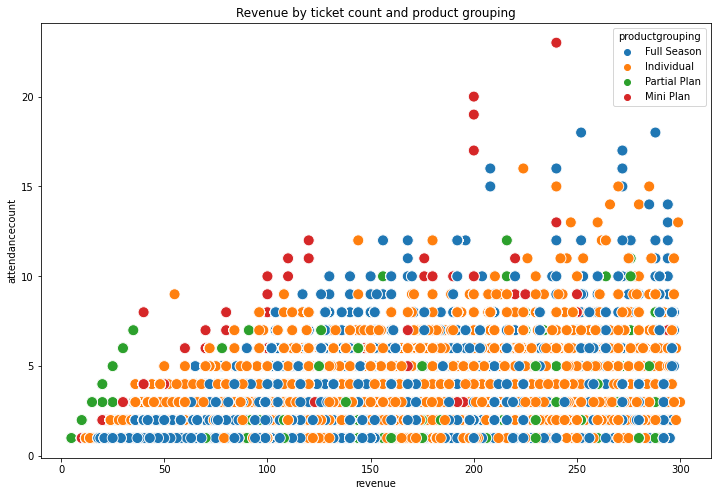

In [37]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="revenue", y="attendancecount", data=df[(df["revenue"]<300) & (df["attendancecount"] < 25) & (df["revenue"]>0) & (df["attendancecount"]>0) & (df["productgrouping"] != "Group")], hue="productgrouping", s=120)

plt.title("Revenue by ticket count and product grouping")

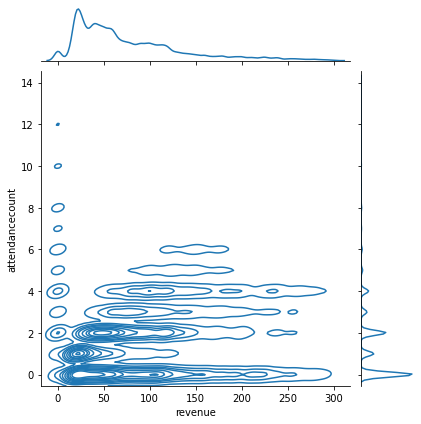

In [35]:
sns.jointplot(x='attendancecount', y='revenue', data=df[(df["revenue"]<300) & (df["attendancecount"] < 15)], kind='kde')

## Violin Plot

I find the violin plot one of the best for showing distributions between groups. Its quite easy as shown below to see where the spending tends to lean for the amount of games the person attends.

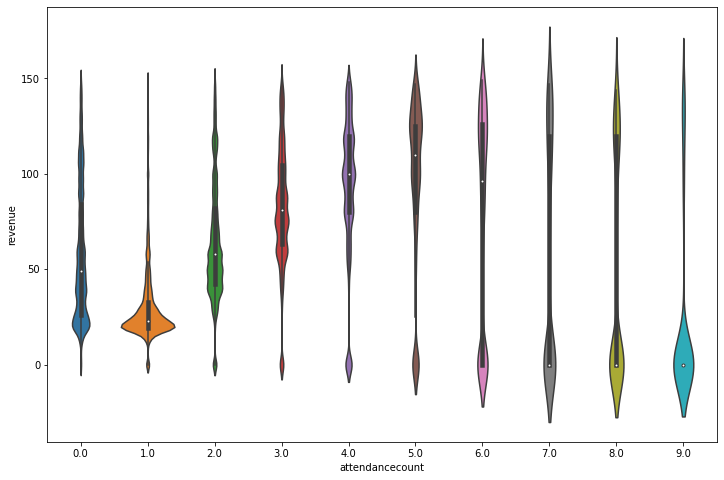

In [28]:
plt.figure(figsize=(12,8))

sns.violinplot(x="attendancecount", y="revenue", data=df[(df["attendancecount"] < 10) & (df["revenue"] < 150)])
plt.show()

## Pairwise Relations

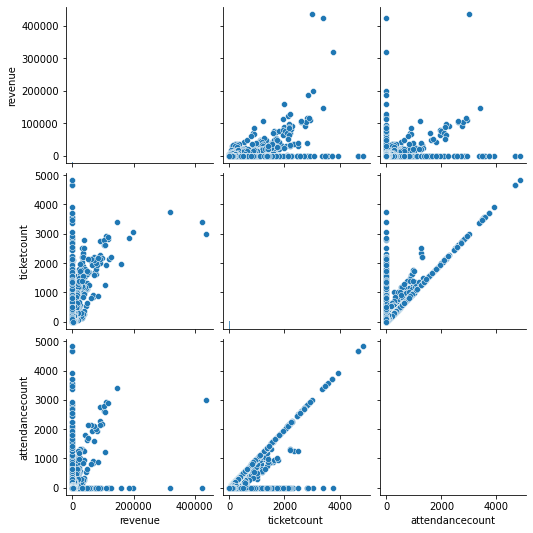

In [32]:
sns.pairplot(df, vars=["revenue", "ticketcount", "attendancecount"])

plt.show()